In [2]:
from __future__ import print_function
import os
from collections import defaultdict
import numpy as np
import pandas as pd
import csv
import json
from utils.data import url_to_class

In [2]:
root = '/data5/Plankton_wi18/rawcolor_db2/'
specimenList = sorted(os.listdir(root + 'images'))

In [3]:
meta_data = defaultdict(list)
for specimen in specimenList:
    meta = json.load(open(os.path.join(root, 'meta', '%s-meta.json' % specimen)))
    for image in meta:
        meta_data['images'].append(image)
        meta_data['width'].append(meta[image]['width'])
        meta_data['height'].append(meta[image]['height'])
meta = pd.DataFrame(meta_data)
# meta

In [4]:
poses = pd.DataFrame(np.load('/data5/morgado/projects/plankton/turk/results/pose.npy').item())
print(len(poses))
poses = pd.merge(poses, meta, on='images')
poses['head_x_rel'] = poses['head_x'] / poses['width']
poses['head_y_rel'] = poses['head_y'] / poses['height']
poses['tail_x_rel'] = poses['tail_x'] / poses['width']
poses['tail_y_rel'] = poses['tail_y'] / poses['height']
poses['specimen_id'] = poses['images'].apply(lambda x: x.split('/')[0])
# poses

88760


In [5]:
classes = pd.read_csv(os.path.join(root, 'classes/specimen_taxonomy.txt'))
# classes

In [6]:
subsets = defaultdict(list)
for specimen in specimenList:
    listFileName = os.path.join(root, 'subsets', '%s-{}.lst' % specimen)
    for phase in ['train', 'valid', 'test']:
        for image in open(listFileName.format(phase)).read().splitlines():
            subsets['images'].append(unicode(image))
            subsets['phase'].append(phase)
subsets = pd.DataFrame(subsets)
# subsets

In [7]:
merge = pd.merge(pd.merge(poses, classes, on='specimen_id'), subsets, on='images')
# merge

## Dataset_1 (outdated)
Dataset is set up, so training and testing is done on the same specimen. This version is outdated.

In [8]:
datasets = {}
for phase in ['train', 'valid', 'test']:
    datasets[phase] = merge[merge['phase'] == phase]
    datasets[phase].to_csv('/data3/ludi/plankton_wi17/pose/poseprediction_torch/data/data_{}.csv'.format(phase))
[len(datasets[phase]) for phase in ['train', 'valid', 'test']]

## Dataset_2 (outdated)
Dataset is set up, so we exclude classes with less than 1 specimen and hold out on one specimen for testing for each class. This version is also outdated as of 4-18-18

In [61]:
genus_to_specimens = defaultdict(set)
collected_specimens = set(poses.specimen_id.unique())
for i, row in classes.iterrows():
    specimen_id, genus = row['specimen_id'], row['genus']
    if specimen_id in collected_specimens:
        genus_to_specimens[genus].add(specimen_id)
filtered_genus = filter(lambda x: len(genus_to_specimens[x]) > 1 and x != 'UNKNOWN', genus_to_specimens)
dataset_all = {genus: list(genus_to_specimens[genus]) for genus in filtered_genus}

def leave_one_out(dataset):
    test_set = [np.random.choice(dataset[cls]) for cls in dataset]
    train_set = sum([[specimen for specimen in dataset[cls] if specimen not in test_set] for cls in dataset], [])
    return train_set, test_set

for i in range(10):
    train_set, test_set = leave_one_out(dataset_all)
    genus_subset = pd.DataFrame({'specimen_id': train_set + test_set, 
                                  'phase': ['train'] * len(train_set) + ['test'] * len(test_set)})
    merge1 = pd.merge(poses, pd.merge(genus_subset, classes))
    print([merge1[merge1['phase']==phase].genus.nunique() for phase in ['train', 'test']])
    print([len(merge1[merge1['phase']==phase]) for phase in ['train', 'test']])
    print([merge1[merge1['phase']==phase].specimen_id.nunique() for phase in ['train', 'test']])
#     merge1.loc[(merge1['phase'] == 'train') & (rands < 0.1666667), 'phase'] = 'valid'
    for phase in ['train', 'test']:
        to_write = merge1[merge1['phase'] == phase]
        to_write.to_csv('/data3/ludi/plankton_wi17/pose/poseprediction_torch/data/pose_class/data_{}_{}.csv'.format(phase, i))

[19, 19]
[69883, 15500]
[85, 19]
[19, 19]
[68723, 16660]
[85, 19]
[19, 19]
[68776, 16607]
[85, 19]
[19, 19]
[69664, 15719]
[85, 19]
[19, 19]
[68381, 17002]
[85, 19]
[19, 19]
[68989, 16394]
[85, 19]
[19, 19]
[70282, 15101]
[85, 19]
[19, 19]
[70007, 15376]
[85, 19]
[19, 19]
[68180, 17203]
[85, 19]
[19, 19]
[68106, 17277]
[85, 19]


In [38]:
for g in filtered_genus:
    print(g)
    for s in dataset_all[g]:
        print(s, len(poses[poses['specimen_id']==s]))

Tortanus
20170223_002 636
20170509_001 986
Ostracoda (class) (Order)
20170203_002 1005
20170209_003 486
Centropagidae (Family)
20170213_003 996
20170209_001 490
20170504_003 989
20170214_002 1029
20170214_003 1104
20170303_005 758
20170207_001 1041
20170223_001 536
20170427_004 832
20170425_004 999
Appendicularia (class) (Order)
20170420_001 959
20170126_001 547
Centropages
20170203_001 885
20170126_003 999
Brachyura (Family)
20170130_003 936
20170214_001 1006
20170221_004 999
20170221_005 500
20170221_003 509
20170221_001 1009
Euphausiidae (Family)
20170207_006 824
20170504_006 995
20170221_002 999
20170206_002 1130
Oithonidae (Family)
20170216_001 1000
20170224_004 509
20170216_004 498
20170509_004 984
20170217_006 507
Poecilostomatoida (Family)
20170516_002 1042
20170516_001 1007
20170213_001 1009
20170216_002 1159
20170124_002 978
20170217_003 529
20170224_005 440
20170516_007 997
Acartia
20170425_005 918
20170307_002 746
20170303_004 540
Polychaeta (class) (Order)
20170302_002 530

In [27]:
for i in range(10):
    train, test = (pd.read_csv('/data3/ludi/plankton_wi17/pose/poseprediction_torch/data/pose_class/data_{}_{}.csv'.format(phase, i))
                for phase in ['train', 'test'])
    g1 = (sorted(list(train['genus'].unique())))
    break
g2 = sorted(filtered_genus)
zip(g1, g2)

[('Acartia', 'Acartia'),
 ('Acartiidae (Family)', 'Acartiidae (Family)'),
 ('Appendicularia (class) (Order)', 'Appendicularia (class) (Order)'),
 ('Brachyura (Family)', 'Brachyura (Family)'),
 ('Calanoida (Order)', 'Calanoida (Order)'),
 ('Calanus', 'Calanus'),
 ('Candaciidae (Family)', 'Candacia'),
 ('Centropages', 'Candaciidae (Family)'),
 ('Centropagidae (Family)', 'Centropages'),
 ('Cydippida (Order)', 'Centropagidae (Family)'),
 ('Euphausiidae (Family)', 'Cydippida (Order)'),
 ('Gammaridae (Family)', 'Euphausiidae (Family)'),
 ('Hydromedusae (Order)', 'Gammaridae (Family)'),
 ('Mysida (Order)', 'Hydromedusae (Order)'),
 ('Oithonidae (Family)', 'Mysida (Order)'),
 ('Ostracoda (class) (Order)', 'Oithonidae (Family)'),
 ('Poecilostomatoida (Family)', 'Ostracoda (class) (Order)'),
 ('Polychaeta (class) (Order)', 'Poecilostomatoida (Family)'),
 ('Tortanus', 'Polychaeta (class) (Order)')]

In [20]:
from dataset import DatasetWrapper
import os
import pandas as pd
from collections import defaultdict

for i in range(10):
    dd = defaultdict(list)
    for phase in ['train', 'test']:
        csv_filename = os.path.join('data/', 'pose_class/data_%s_%d.csv' % (phase, i))
        df = pd.read_csv(csv_filename)
#         print(phase)
        for g in df.genus.unique():
            dg = df[df['genus']==g]
            dd[g].append(dg.specimen_id.nunique())
#             print(g, dg.specimen_id.nunique())
#             for s in dg.specimen_id.unique():
#                 print(s, len(dg[dg['specimen_id']==s]))
    print(dd)
#     break

defaultdict(<type 'list'>, {'Mysida (Order)': [2, 1], 'Oithonidae (Family)': [4, 1], 'Hydromedusae (Order)': [11, 1], 'Acartiidae (Family)': [4, 1], 'Poecilostomatoida (Family)': [7, 1], 'Ostracoda (class) (Order)': [1, 1], 'Acartia': [2, 1], 'Calanus': [1, 1], 'Centropagidae (Family)': [9, 1], 'Gammaridae (Family)': [10, 1], 'Polychaeta (class) (Order)': [11, 1], 'Candaciidae (Family)': [2, 1], 'Tortanus': [1, 1], 'Appendicularia (class) (Order)': [1, 1], 'Calanoida (Order)': [9, 1], 'Centropages': [1, 1], 'Cydippida (Order)': [1, 1], 'Brachyura (Family)': [5, 1], 'Euphausiidae (Family)': [3, 1]})
defaultdict(<type 'list'>, {'Mysida (Order)': [2, 1], 'Gammaridae (Family)': [10, 1], 'Hydromedusae (Order)': [11, 1], 'Acartiidae (Family)': [4, 1], 'Ostracoda (class) (Order)': [1, 1], 'Poecilostomatoida (Family)': [7, 1], 'Acartia': [2, 1], 'Calanus': [1, 1], 'Centropagidae (Family)': [9, 1], 'Oithonidae (Family)': [4, 1], 'Polychaeta (class) (Order)': [11, 1], 'Candaciidae (Family)': [2,

## Dataset_3 (outdated version)
This dataset excludes classes with less than 3 specimens and combines subclasses into their superclasses.

In [8]:
# Clean up label typos & drop superclasses
classes['family'][classes['family'] == 'Sergestidae'] = 'Brachyura'
classes['family'][classes['family'] == 'Acartidae'] = 'Acartiidae'
classes1 = classes[classes['family'] != 'Calanoida (Order)']

# Map images to specimens to classes to dataset
family_to_specimens = defaultdict(set)
collected_specimens = set(poses.specimen_id.unique())
for i, row in classes1.iterrows():
    family, specimen_id = row['family'], row['specimen_id']
    if specimen_id in collected_specimens:
        family_to_specimens[family].add(specimen_id)
print('Original number of classes: {}'.format(len(family_to_specimens.keys())))
filtered_family = filter(lambda x: len(family_to_specimens[x]) > 2 and x != 'UNKNOWN', family_to_specimens)
print('New number of classes (excluding classes w/ < 2 specimens & Unknown): {}'.format(len(filtered_family)))

print()
dataset_all = {family: list(family_to_specimens[family]) for family in filtered_family}
print('New dataset: (X) ~ # of specimens')
for i, cls in enumerate(dataset_all):
    print('{}. {} ({})'.format(i+1, cls, len(dataset_all[cls])))

print()
excludedClasses = [cls for cls in family_to_specimens if cls not in filtered_family]
print('List of classes excluded')
for i, cls in enumerate(excludedClasses):
    print('{}. {}'.format(i+1, cls))

Original number of classes: 20
New number of classes (excluding classes w/ < 2 specimens & Unknown): 11

New dataset: (X) ~ # of specimens
1. Mysida (Order) (3)
2. Hydromedusae (Order) (12)
3. Acartiidae (8)
4. Gammaridae (11)
5. Poecilostomatoida (8)
6. Euphausiidae (4)
7. Oithonidae (5)
8. Polychaeta (class) (Order) (12)
9. Centropagidae (12)
10. Brachyura (6)
11. Candaciidae (3)

List of classes excluded
1. Diphyidae
2. Ostracoda (class) (Order)
3. Saggittoidea (class) (Order)
4. Pontellidae
5. Copepoda Nauplia (subclass) (Order)
6. Appendicularia (class) (Order)
7. Calanidae
8. Cydippida (Order)
9. Tortanidae


In [14]:
def leave_one_out(dataset):
    test_set = [np.random.choice(dataset[cls]) for cls in dataset]
    train_set = sum([[specimen for specimen in dataset[cls] if specimen not in test_set] for cls in dataset], [])
    return train_set, test_set

dest_path = '/data5/lekevin/plankton/poseprediction/poseprediction_torch/data/3'
for i in range(10):
    train_set, test_set = leave_one_out(dataset_all)
    family_subset = pd.DataFrame({'specimen_id': train_set + test_set, 
                                  'phase': ['train'] * len(train_set) + ['test'] * len(test_set)})
    merge1 = pd.merge(poses, pd.merge(family_subset, classes1))
    
    print('Dataset {} ([Train,Test]) nCls:{}, nImgs:{}, nSpc:{}'.format(i,
[merge1[merge1['phase']==phase].family.nunique() for phase in ['train', 'test']], # Validate #ofClasses
[len(merge1[merge1['phase']==phase]) for phase in ['train', 'test']], # Verify #ofImgs
[merge1[merge1['phase']==phase].specimen_id.nunique() for phase in ['train', 'test']] )) # Validate #ofSpcIds
    
#     for phase in ['train', 'test']:
#         to_write = merge1[merge1['phase'] == phase]
#         to_write.to_csv(dest_path+ '/data_{}_{}.csv'.format(phase, i))

Dataset 0 ([Train,Test]) nCls:[11, 11], nImgs:[58496, 9281], nSpc:[73, 11]
Dataset 1 ([Train,Test]) nCls:[11, 11], nImgs:[58872, 8905], nSpc:[73, 11]
Dataset 2 ([Train,Test]) nCls:[11, 11], nImgs:[59259, 8518], nSpc:[73, 11]
Dataset 3 ([Train,Test]) nCls:[11, 11], nImgs:[58513, 9264], nSpc:[73, 11]
Dataset 4 ([Train,Test]) nCls:[11, 11], nImgs:[59229, 8548], nSpc:[73, 11]
Dataset 5 ([Train,Test]) nCls:[11, 11], nImgs:[58920, 8857], nSpc:[73, 11]
Dataset 6 ([Train,Test]) nCls:[11, 11], nImgs:[58823, 8954], nSpc:[73, 11]
Dataset 7 ([Train,Test]) nCls:[11, 11], nImgs:[59276, 8501], nSpc:[73, 11]
Dataset 8 ([Train,Test]) nCls:[11, 11], nImgs:[57810, 9967], nSpc:[73, 11]
Dataset 9 ([Train,Test]) nCls:[11, 11], nImgs:[59440, 8337], nSpc:[73, 11]


## Dataset_4 (current version)
We continue to use dataset 3's training and testing csv data files, but duplicate images to fix class imbalance with problematic classes. 

In [12]:
src_path = '/data5/lekevin/plankton/poseprediction/poseprediction_torch/data/3'
trainFiles = [os.path.join(src_path,i) for i in sorted(os.listdir(src_path)) if 'train' in i]
for i in range(10):
    
    # Read in data
    traindf = pd.read_csv(trainFiles[i])

    def fix_class_imbalance(df, cls, maxImgs):
        df_try = df.get_group(cls)
        clsSize = df_try.shape[0]
        sizeDiff = (maxImgs-clsSize)
        if sizeDiff > clsSize:
            duplicateSize = int((maxImgs-clsSize)/float(clsSize))
            df_add = df_try.sample(n=maxImgs%clsSize, replace=True).append([df_try]*duplicateSize, ignore_index=True)
        else:
            df_add = df_try.sample(n=sizeDiff, replace=True)
        return df_add

    # Fix class imbalance
    imgsCls = traindf['family'].value_counts().to_dict()
    maxImgs = max(imgsCls.values())
    groupsCls = traindf.groupby(traindf['family'])
    for cls in imgsCls:
        if imgsCls[cls] < maxImgs:
            df_add = fix_class_imbalance(groupsCls, cls, maxImgs)
            temp = traindf.append(df_add, ignore_index=True)
            traindf = temp

    # Display dataset statistics
    merge2 = traindf
    print(merge2['family'][merge2['phase'] == 'train'].value_counts())
    print('Dataset {} ([Train]) nCls:{}, nImgs:{}, nSpc:{}'.format(i,
    [merge2[merge2['phase']==phase].family.nunique() for phase in ['train']], # Validate #ofClasses
    [len(merge2[merge2['phase']==phase]) for phase in ['train']], # Verify #ofImgs
    [merge2[merge2['phase']==phase].specimen_id.nunique() for phase in ['train']] )) # Validate #ofSpcIds

    dest_path = '/data5/lekevin/plankton/poseprediction/poseprediction_torch/data/4'
    if not os.path.exists(dest_path):
        os.makedirs(dest_path)
    for phase in ['train']:
        to_write = merge2[merge2['phase'] == phase]
        print('/data_{}_{}.csv written'.format(phase, i))
        to_write.to_csv(dest_path+ '/data_{}_{}.csv'.format(phase, i))

Gammaridae                    9629
Euphausiidae                  9629
Polychaeta (class) (Order)    9629
Acartiidae                    9629
Mysida (Order)                9629
Candaciidae                   9629
Oithonidae                    9629
Brachyura                     9629
Poecilostomatoida             9629
Centropagidae                 9629
Hydromedusae (Order)          9629
Name: family, dtype: int64
Dataset 0 ([Train]) nCls:[11], nImgs:[105919], nSpc:[73]
/data_train_0.csv written
Gammaridae                    9659
Euphausiidae                  9659
Polychaeta (class) (Order)    9659
Acartiidae                    9659
Mysida (Order)                9659
Candaciidae                   9659
Oithonidae                    9659
Brachyura                     9659
Poecilostomatoida             9659
Centropagidae                 9659
Hydromedusae (Order)          9659
Name: family, dtype: int64
Dataset 1 ([Train]) nCls:[11], nImgs:[106249], nSpc:[73]
/data_train_1.csv written
Gammaridae

In [15]:
import shutil
src_path = '/data5/lekevin/plankton/poseprediction/poseprediction_torch/data/3'
testFiles = [os.path.join(src_path,i) for i in sorted(os.listdir(src_path)) if 'test' in i]
dest_path = '/data5/lekevin/plankton/poseprediction/poseprediction_torch/data/4'
newTestFiles =[os.path.join(dest_path,i) for i in sorted(os.listdir(src_path)) if 'test' in i]
for i, j in zip(testFiles, newTestFiles):
    print('{} copied'.format(os.path.basename(i)))
    shutil.copyfile(i,j)

data_test_0.csv copied
data_test_1.csv copied
data_test_2.csv copied
data_test_3.csv copied
data_test_4.csv copied
data_test_5.csv copied
data_test_6.csv copied
data_test_7.csv copied
data_test_8.csv copied
data_test_9.csv copied


# Review training and testing specimens

In [17]:
from utils.data import *
from dataset import PlanktonDataset
from logger import Logger
from utils.constants import *

from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
def set_root(root):
    phases = [TRAIN, TEST]
    img_dir = '/data5/Plankton_wi18/rawcolor_db2/images'
    args = Logger.read_meta(os.path.join(root, 'meta.txt'))
    datasetVersion = 3
    csv_filename = os.path.join(args.data, '{}/data_{}_%d.csv'%args.dataset_id)
    dataset = {phase: PlanktonDataset(csv_file=csv_filename.format(datasetVersion, phase),
                             img_dir = img_dir,
                             amp = args.amp,
                             std = args.std) for phase in phases}
    return dataset

datasetIDs = [0]
root = '/data5/lekevin/plankton/poseprediction/poseprediction_torch/records/resnet50/class_2a/{}'.format (datasetIDs[-1])
dataset = set_root(root)

In [23]:
def get_cls_idx(dataset_df, level):
    specimen_to_img = dataset_df['images'].groupby(dataset_df['specimen_id']).apply(list).to_dict()
    classes_to_specimen = dataset_df['specimen_id'].groupby(dataset_df[level]).apply(list).to_dict()
    classes_to_specimen = {classes:set(classes_to_specimen[classes]) for classes in classes_to_specimen}
    dataset = {}
    for classes in classes_to_specimen:
        dataset[classes] = {spc:specimen_to_img[spc] for spc in classes_to_specimen[classes]}
    return dataset

img_dir = '/data5/Plankton_wi18/rawcolor_db2/images'
train_set = get_cls_idx(dataset[TRAIN].data, FAMILY)
test_set = get_cls_idx(dataset[TEST].data, FAMILY)
print('List of Classes')
for i,cls in enumerate(sorted(train_set)):
    print("{}. {} ({} images)".format(i+1,cls, sum([len(train_set[cls][spc]) for spc in train_set[cls]])))

List of Classes
1. Acartiidae (5155 images)
2. Brachyura (3960 images)
3. Candaciidae (1544 images)
4. Centropagidae (9629 images)
5. Euphausiidae (2949 images)
6. Gammaridae (7125 images)
7. Hydromedusae (Order) (9059 images)
8. Mysida (Order) (1486 images)
9. Oithonidae (2514 images)
10. Poecilostomatoida (6721 images)
11. Polychaeta (class) (Order) (8354 images)


## Class Visualization

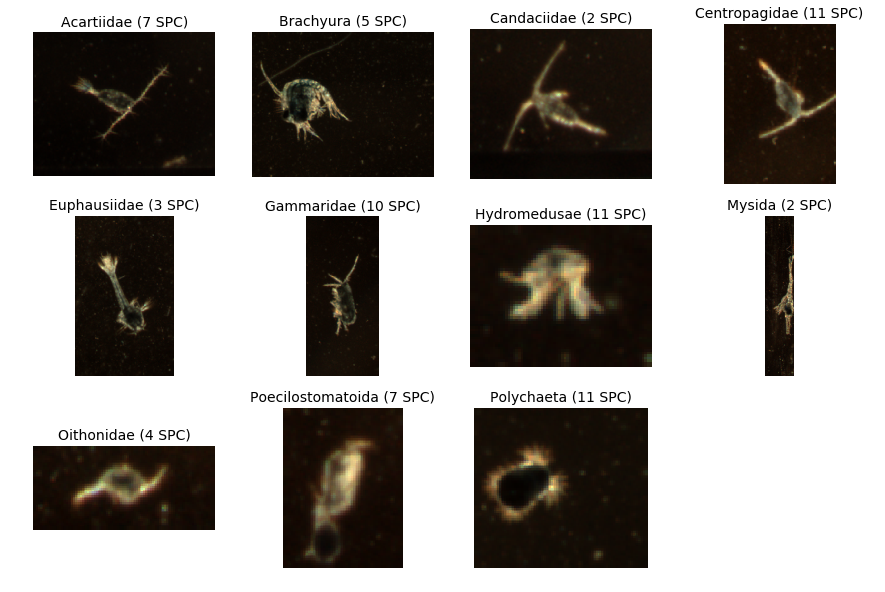

In [24]:
numCols = 4
numRows = int(max(len(train_set)/numCols+1,2))
numPlots = int(np.ceil(numRows / 5.))
for p in range(numPlots):
    fig, axarr = plt.subplots(min(numRows, 5),numCols, figsize=(15,10))
    for i in range(len(axarr)):
        for j in range(len(axarr[0])):
            axarr[i,j].set_axis_off()
tempSortedClsList = ['Centropages', 'Ostracoda (class) (Order)', 'Calanus', 'Candaciidae (Family)', 'Tortanus', 'Acartia', 'Mysida (Order)', 'Centropagidae (Family)', 'Cydippida (Order)', 'Calanoida (Order)', 'Polychaeta (class) (Order)', 'Brachyura (Family)', 'Oithonidae (Family)', 'Euphausiidae (Family)', 'Appendicularia (class) (Order)', 'Poecilostomatoida (Family)', 'Acartiidae (Family)', 'Gammaridae (Family)', 'Hydromedusae (Order)']
tempSortedClsList1 = ['Euphausiidae (Family)', 'Tortanus', 'Cydippida (Order)', 'Centropages', 'Calanoida (Order)', 'Appendicularia (class) (Order)', 'Candaciidae (Family)', 'Polychaeta (class) (Order)', 'Oithonidae (Family)', 'Centropagidae (Family)'
, 'Calanus', 'Acartia', 'Ostracoda (class) (Order)', 'Brachyura (Family)', 'Poecilostomatoida (Family)', 'Acartiidae (Family)', 'Hydromedusae (Order)', 'Gammaridae (Family)', 'Mysida (Order)']  
for iAx, cls in enumerate(sorted(train_set)):
# for iAx, cls in enumerate(tempSortedClsList1):
    spc = np.random.choice(train_set[cls].keys())
    numSpc = len(train_set[cls].keys())
    idx = np.random.choice(train_set[cls][spc])
    img = plt.imread(os.path.join(img_dir, idx))
    axarr[iAx/numCols,iAx%numCols].imshow(img)
    axarr[iAx/numCols,iAx%numCols].set_axis_off()
    axarr[iAx/numCols,iAx%numCols].set_title('{} ({} SPC)'.format(cls.split()[0], numSpc), fontsize=14)
plt.show()

### Class-sorted specimen visualization

=> 1. Mysida: Train 2, Test 1


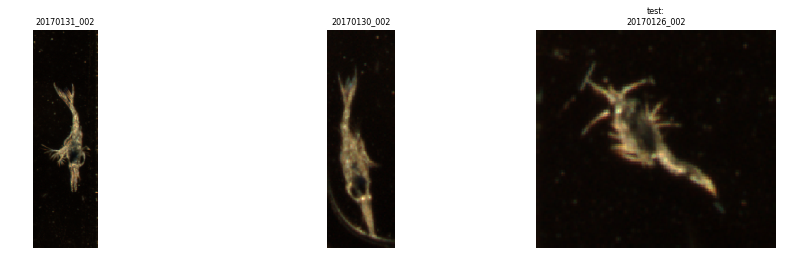

=> 2. Hydromedusae: Train 11, Test 1


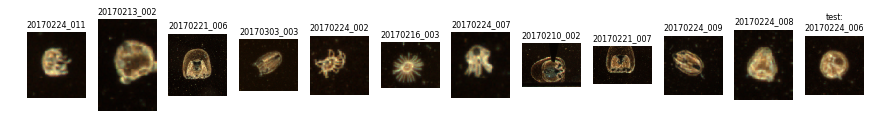

=> 3. Acartiidae: Train 7, Test 1


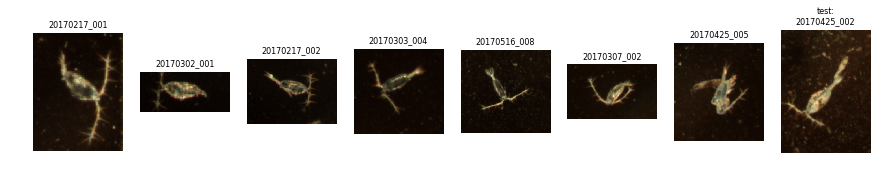

=> 4. Gammaridae: Train 10, Test 1


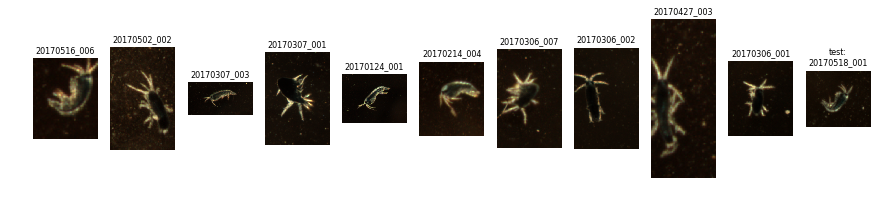

=> 5. Poecilostomatoida: Train 7, Test 1


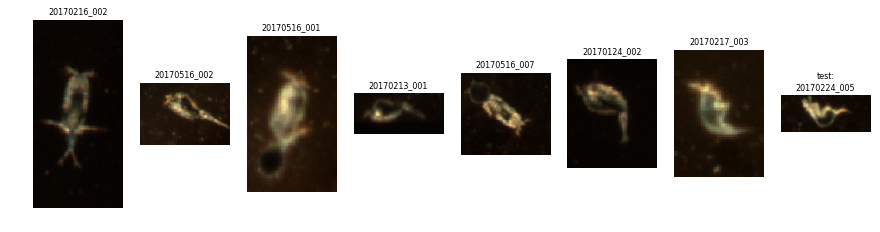

=> 6. Candaciidae: Train 2, Test 1


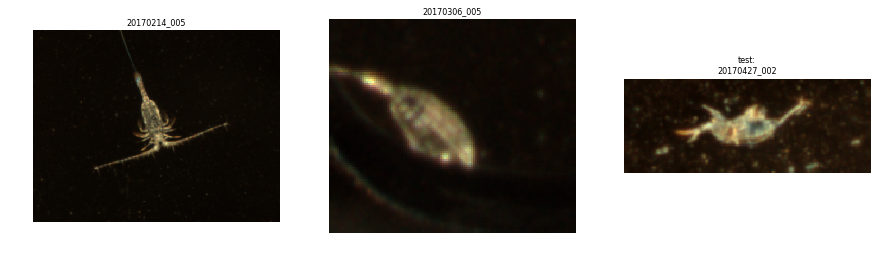

=> 7. Oithonidae: Train 4, Test 1


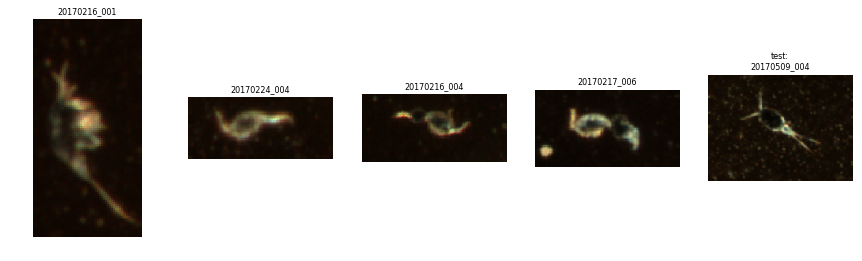

=> 8. Polychaeta: Train 11, Test 1


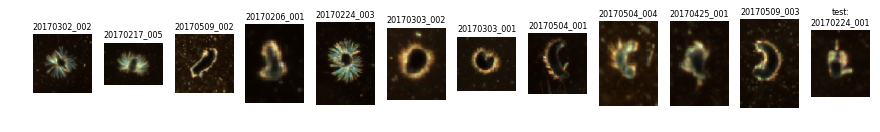

=> 9. Centropagidae: Train 11, Test 1


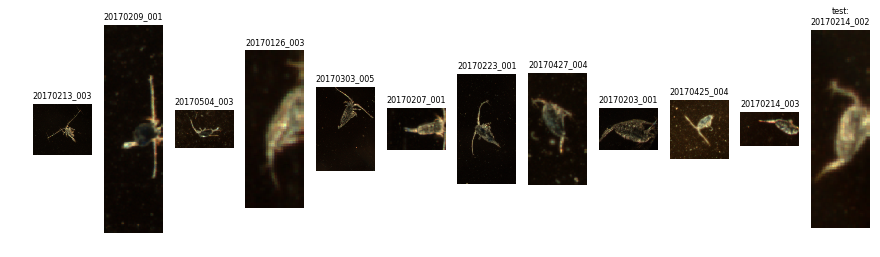

=> 10. Brachyura: Train 5, Test 1


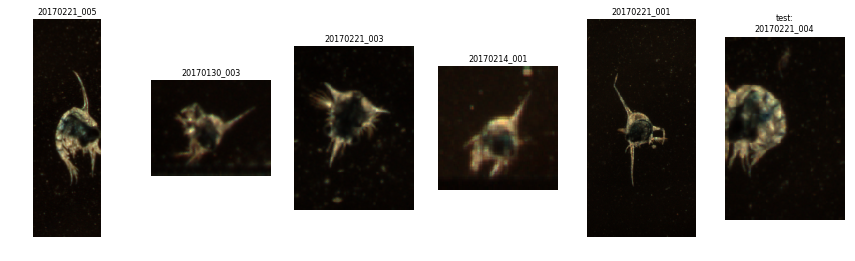

=> 11. Euphausiidae: Train 3, Test 1


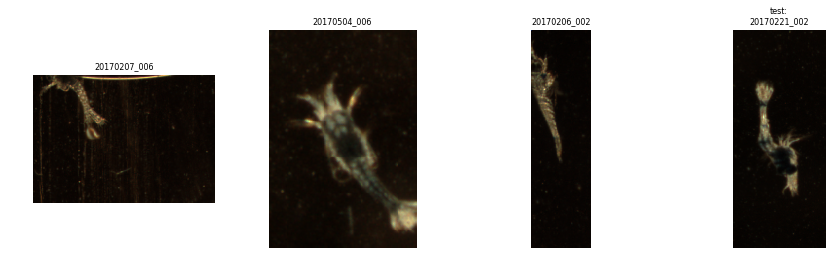

In [25]:
trainDF = dataset[TRAIN].data
testDF = dataset[TEST].data
for i,cls in enumerate(train_set):
    numCol = len(set(train_set[cls])) + 1
    print('=> {}. {}: Train {}, Test 1'.format(i+1, cls.split()[0], len(set(train_set[cls]))))
    fig, axarr = plt.subplots(1, numCol, figsize=(15,4))
    for j,spc in enumerate(set(train_set[cls])):
        idx = np.random.choice(train_set[cls][spc])
        img = plt.imread(os.path.join(img_dir, idx))
        axarr[j].imshow(img)
        axarr[j].set_axis_off()
        axarr[j].set_title('{}'.format(spc), fontsize=8)
    for spc in test_set[cls]:
        idx = np.random.choice(test_set[cls][spc])
        img = plt.imread(os.path.join(img_dir, idx))
        axarr[-1].imshow(img)
        axarr[-1].set_axis_off()
        axarr[-1].set_title('test:\n{}'.format(spc), fontsize=8)
    plt.show()


=> 1. Acartia: Train 2, Test 1
=> 2. Acartiidae: Train 4, Test 1
=> 3. Appendicularia: Train 1, Test 1
=> 4. Brachyura: Train 5, Test 1
=> 5. Calanoida: Train 9, Test 1
=> 6. Calanus: Train 1, Test 1
=> 7. Candaciidae: Train 2, Test 1
=> 8. Centropages: Train 1, Test 1
=> 9. Centropagidae: Train 9, Test 1
=> 10. Cydippida: Train 1, Test 1
=> 11. Euphausiidae: Train 3, Test 1
=> 12. Gammaridae: Train 10, Test 1
=> 13. Hydromedusae: Train 11, Test 1
=> 14. Mysida: Train 2, Test 1
=> 15. Oithonidae: Train 4, Test 1
=> 16. Ostracoda: Train 1, Test 1
=> 17. Poecilostomatoida: Train 7, Test 1
=> 18. Polychaeta: Train 11, Test 1
=> 19. Tortanus: Train 1, Test 1


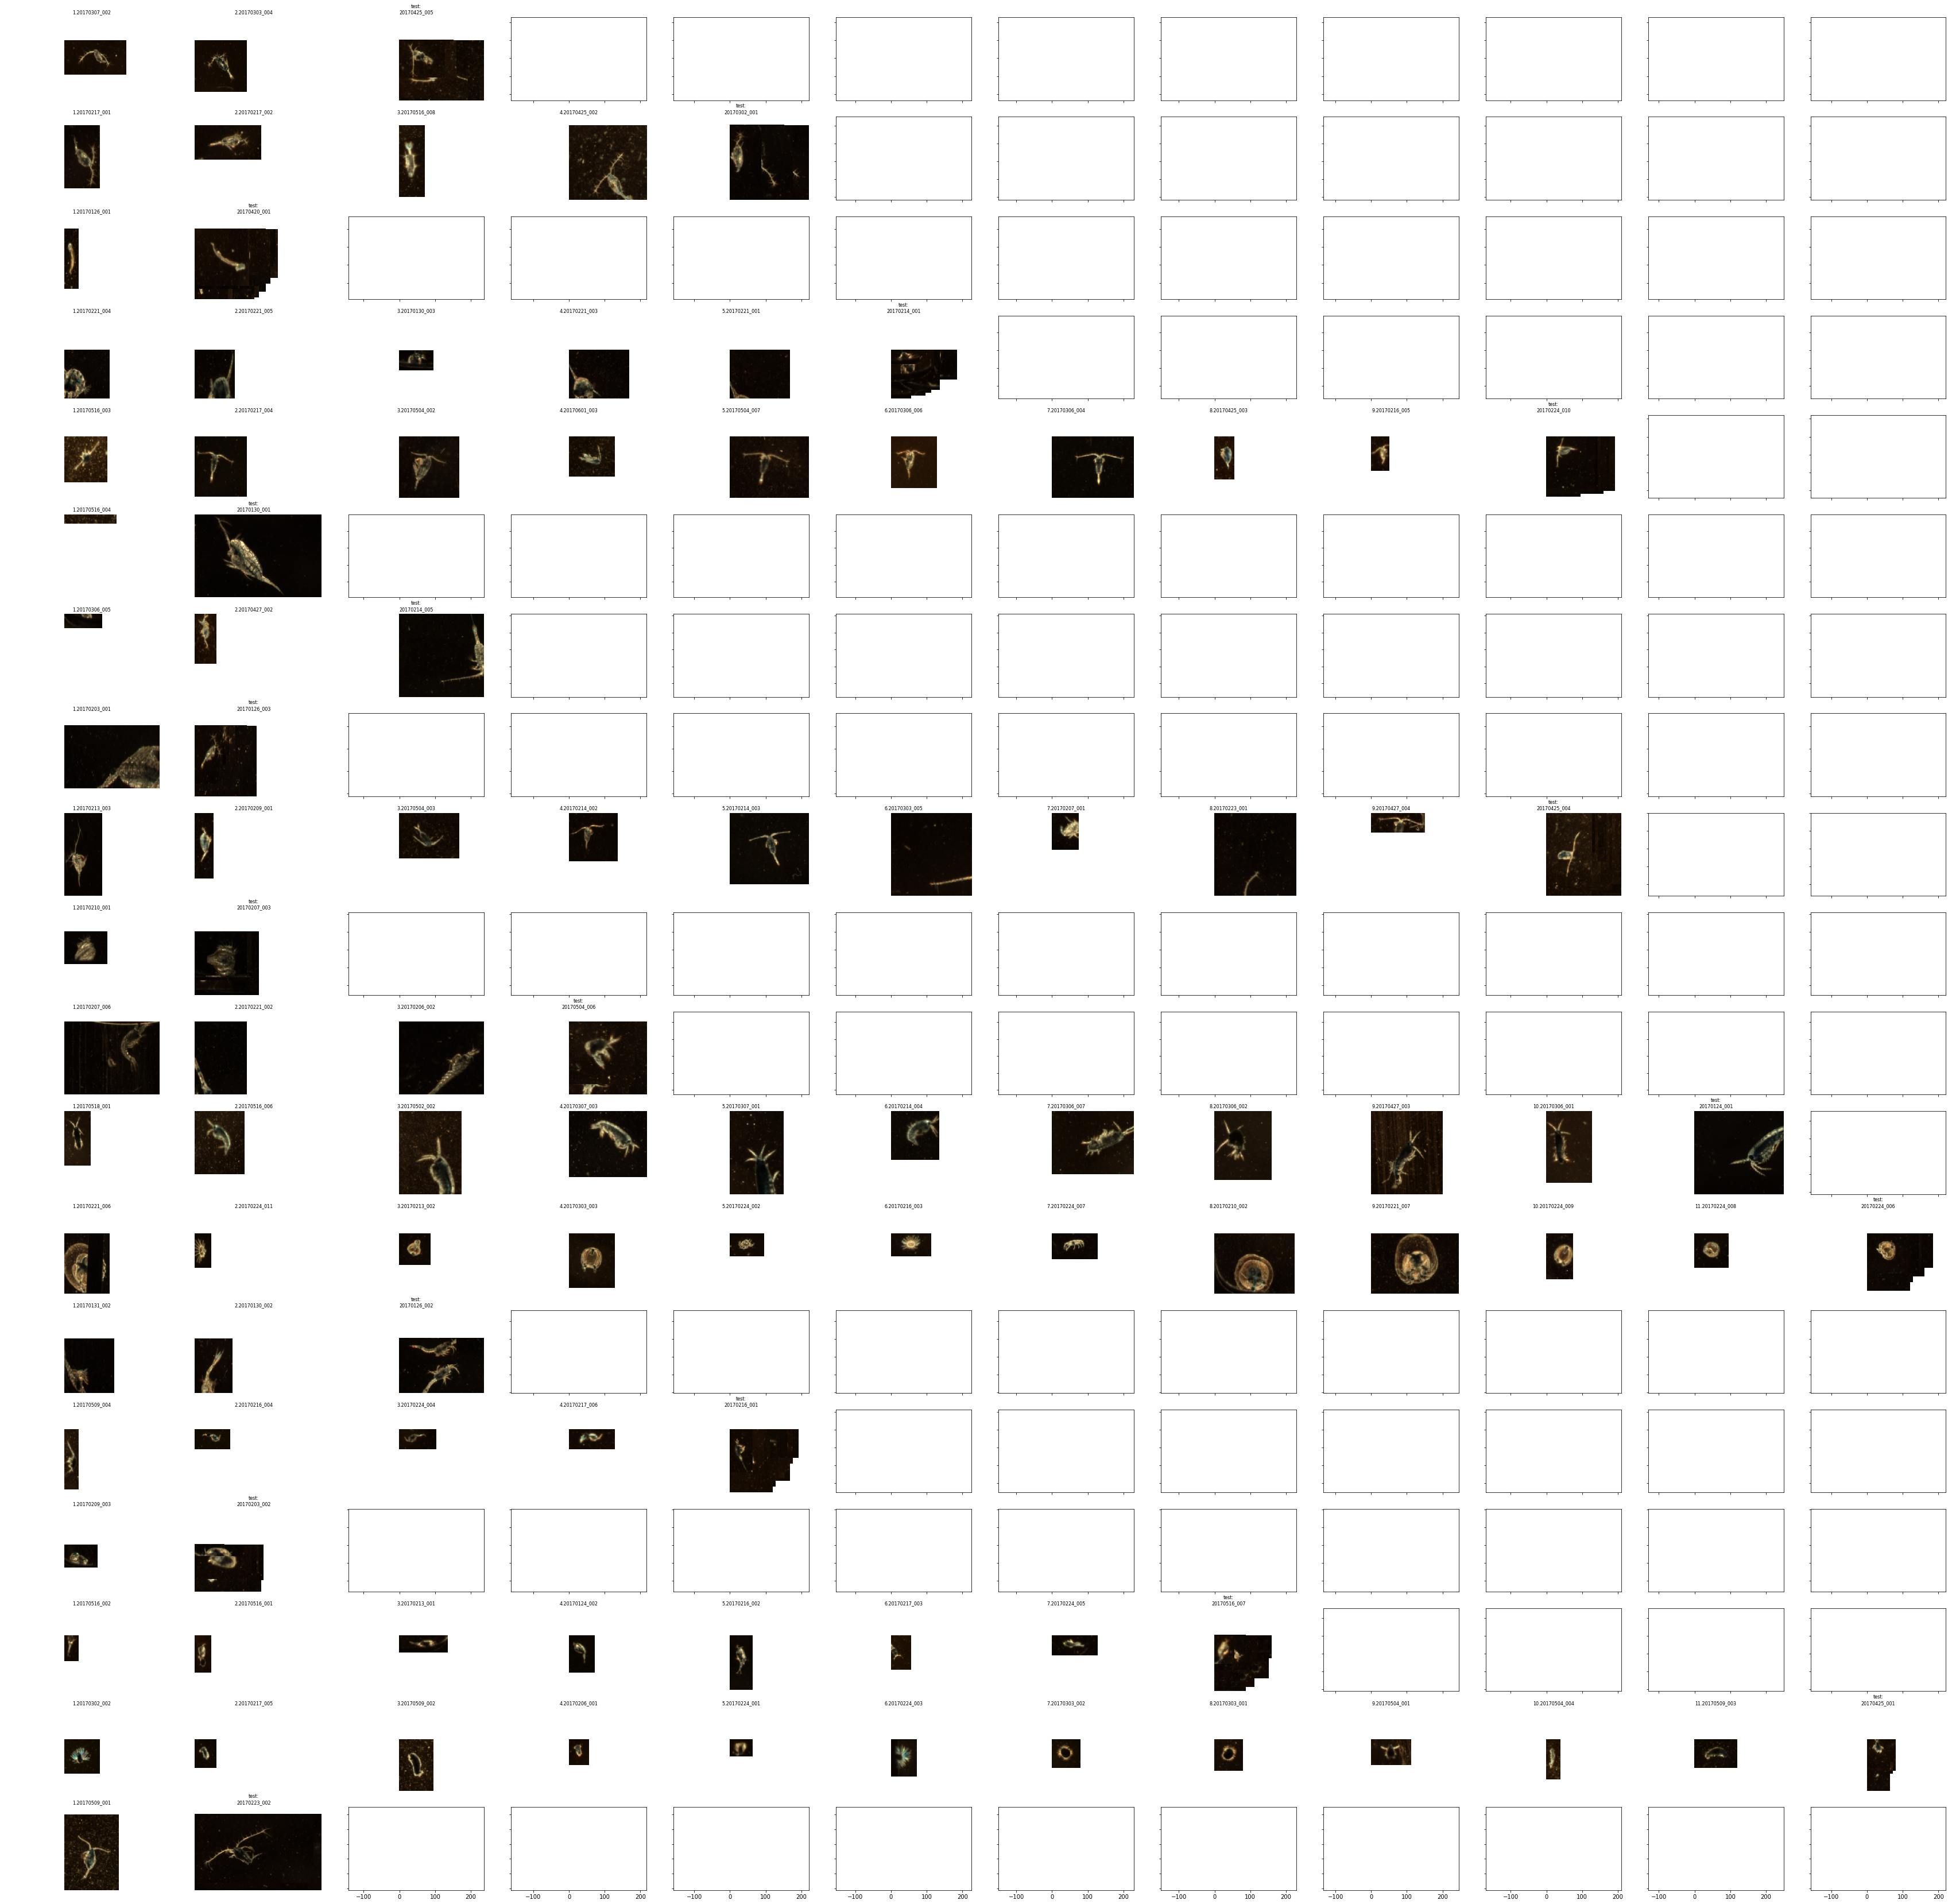

In [5]:
trainDF = placeholder.dataset[TRAIN].dataset.data
testDF = placeholder.dataset[TEST].dataset.data
numRows = len(train_set.keys())
numCols = max(len(train_cls_idx[cls]) for cls in train_cls_idx) + 1
fig, axarr = plt.subplots(numRows, numCols, figsize=(100,60),sharex='col', sharey='row')
for i,cls in enumerate(sorted(train_set)):
    print('=> {}. {}: Train {}, Test 1'.format(i+1, cls.split()[0], len(set(train_set[cls]))))
    for j,spc in enumerate(set(train_set[cls])):
        idx = np.random.choice(train_cls_idx[cls][spc])
        img = plt.imread(os.path.join(img_dir, trainDF['images'][idx]))
        axarr[i,j].imshow(img)
        axarr[i,j].set_axis_off()
        axarr[i,j].set_title('{}.{}'.format(j+1,trainDF['specimen_id'][idx]), fontsize=12)
    for spc in test_set[cls]:
        idx = np.random.choice(test_cls_idx[cls][spc])
        img = plt.imread(os.path.join(img_dir, testDF['images'][idx]))
        axarr[i,j+1].imshow(img)
        axarr[i,j+1].set_axis_off()
        axarr[i,j+1].set_title('test:\n{}'.format(testDF['specimen_id'][idx]), fontsize=12)
plt.show()